In [1]:
import awkward as ak
import numpy as np
import uproot as uproot
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
# import tensorflow as tf
import glob
from numba import jit
import pickle
import os, errno
import time 
import mplhep as hep
plt.style.use(hep.style.CMS)

In [6]:
file = '/eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/multi_particle/ntuples_10_600/new_ntuples_14162307_1020.root'

In [7]:
f = uproot.open(file)

In [8]:
f.keys()

['ticlNtuplizer;1',
 'ticlNtuplizer/tracksters;1',
 'ticlNtuplizer/clusters;1',
 'ticlNtuplizer/graph;1',
 'ticlNtuplizer/candidates;1',
 'ticlNtuplizer/trackstersMerged;1',
 'ticlNtuplizer/associations;1',
 'ticlNtuplizer/simtrackstersSC;1',
 'ticlNtuplizer/simtrackstersCP;1',
 'ticlNtuplizer/tracks;1']

In [2]:
def mkdir_p(mypath):
    '''Function to create a new directory, if it not already exist
        - mypath : directory path
    '''
    from errno import EEXIST
    from os import makedirs,path
    try:
        makedirs(mypath)
    except OSError as exc:
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise



In [3]:
@jit
def computeEdgeAndLabels(trk_data, ass_data, gra_data, nodes, edges, edges_labels, best_simTs_match):
    '''Compute the truth graph'''
    for i in range(trk_data.NTracksters):
        nodes.append(i)
        qualities = ass_data.tsCLUE3D_recoToSim_CP_score[i]
        best_sts_i = ass_data.tsCLUE3D_recoToSim_CP[i][ak.argmin(qualities)]
        best_simTs_match.append(best_sts_i)
        #best_sts_i = best_sts_i if qualities[best_sts_i]<0.1 else -1
        for j in gra_data.linked_inners[i]:
            edges.append([j,i])
            qualities = ass_data.tsCLUE3D_recoToSim_CP_score[j]
            best_sts_j = ass_data.tsCLUE3D_recoToSim_CP[j][ak.argmin(qualities)]
            #best_sts_j = best_sts_j if qualities[best_sts_j]<0.1 else -1
            if best_sts_i == best_sts_j:
                edges_labels.append(1)
            else:
                edges_labels.append(0)

In [ ]:
# input_folder = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/close_by_double_pion/production/new_new_ntuples/"
input_folder = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/"
files = glob.glob(f"{input_folder}/*ntuples_*.root")

outputPath  = './dataset_closeByDoublePion/'
mkdir_p(outputPath)

cum_events = 0

N = 10000000
offset = 102
X = [ ]
Edges = [ ]
Edges_labels = [ ] 
energyOnLayers = []   
for i_file, file in enumerate(files[offset:]):
    i_file = i_file + offset
    if i_file >= N: break
    try:
        with uproot.open(file) as f:
        #f = uproot.open(file)
            t =  f["ticlNtuplizer/tracksters"]
            calo = f["ticlNtuplizer/simtrackstersCP"]
            ass = f["ticlNtuplizer/associations"]
            gra = f["ticlNtuplizer/graph"]
            l = f['ticlNtuplizer/clusters']

            trk_data = t.arrays(["NTracksters", "raw_energy","raw_em_energy","barycenter_x","barycenter_y","barycenter_z","eVector0_x", "eVector0_y","eVector0_z","EV1","EV2","EV3","vertices_indexes", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3"])
            gra_data = gra.arrays(['linked_inners'])
            ass_data = ass.arrays([ "tsCLUE3D_recoToSim_CP", "tsCLUE3D_recoToSim_CP_score"])
            lcs_t = t.arrays(['vertices_indexes'])
            lcs = l.arrays(['energy', 'cluster_layer_id'])


            print(len(gra_data))
    except:
        print("error ", file)
        continue
    print('\nProcessing file {} Events '.format(file, cum_events), end="")
    
    if(cum_events%1000 == 0):
        print(f"\nEvents {cum_events}")
    
    start = time.time()
    for ev in range(len(lcs)):
        cum_events += 1 + (i_file*100)
        print(".", end="")
        
        trackster_sizes = []
        lcs_ev = lcs[ev]
        tot_t_hgcal_layers = []
        for vertices in trk_data[ev].vertices_indexes:
            trackster_sizes.append(ak.size(vertices))
            t_hgcal_layers = np.zeros(51)            
            lcs_t = lcs_ev[vertices]
            lcs_t_layerId = lcs_t.cluster_layer_id
            for id_i, l_id in enumerate(np.unique(ak.to_numpy(lcs_t_layerId))):
                energy_lcs_t_id = ak.sum(lcs_t[lcs_t.cluster_layer_id == l_id].energy)
                t_hgcal_layers[l_id] = energy_lcs_t_id
        tot_t_hgcal_layers.append(t_hgcal_layers)

        # Save the input variables
        nodes = []
        edges = []
        edges_labels = []
        
        best_simTs_match = []
        computeEdgeAndLabels(trk_data[ev], ass_data[ev], gra_data[ev], nodes, edges, edges_labels, best_simTs_match )
        x_ev = ak.zip({  "barycenter_x": trk_data[ev].barycenter_x,
                         "barycenter_y": trk_data[ev].barycenter_y,
                         "barycenter_z": trk_data[ev].barycenter_z,
                           "eVector0_x": trk_data[ev].eVector0_x,
                           "eVector0_y": trk_data[ev].eVector0_y,
                           "eVector0_z": trk_data[ev].eVector0_z,
                           "EV1": trk_data[ev].EV1,
                           "EV2": trk_data[ev].EV2,
                           "EV3": trk_data[ev].EV3,
                           "sigmaPCA1": trk_data[ev].sigmaPCA1,
                           "sigmaPCA2": trk_data[ev].sigmaPCA2,
                           "sigmaPCA3": trk_data[ev].sigmaPCA3,
                           "size": trackster_sizes,
                           "raw_en": trk_data[ev].raw_energy, 
                           'raw_em_energy': trk_data[ev].raw_em_energy,
                           'energy_on_layer': tot_t_hgcal_layers,
                           'best_st': best_simTs_match
                      })

        X.append(x_ev)

        ed_np = np.array(edges).T
        Edges.append(ed_np)
        Edges_labels.append(edges_labels)        
        
            # Save to disk
        if((cum_events % 500 == 0 and cum_events != 0)):
            stop = time.time()
            print(f"t = {stop-start}")
            print(f"Event: {cum_events} Saving now the pickle data")

            pickle_dir = outputPath
            with open(pickle_dir+"{}_{}_node_features.pkl".format(str(i_file), str(cum_events)), "wb") as fp:   #Pickling
                pickle.dump(X, fp)
            with open(pickle_dir+"{}_{}_edges.pkl".format(str(i_file),str(cum_events)), "wb") as fp:   #Pickling
                pickle.dump(Edges, fp)
            with open(pickle_dir+"{}_{}_edges_labels.pkl".format(str(i_file),str(cum_events)), "wb") as fp:   #Pickling
                pickle.dump(Edges_labels, fp)
            #Emptying arrays
            ed_np = []
            X = [ ]
            Edges = [ ]
            Edges_labels = [ ] 
            energyOnLayers = []   
            start = time.time()

100

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_109.root Events 
Events 0
.

/tmp/ipykernel_514/885370307.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "computeEdgeAndLabels" failed type inference due to: non-precise type pyobject
During: typing of argument at /tmp/ipykernel_514/885370307.py (4)

File "../../../../../../../../tmp/ipykernel_514/885370307.py", line 4:
<source missing, REPL/exec in use?>

  @jit
/tmp/ipykernel_514/885370307.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "computeEdgeAndLabels" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../../../../../../../../tmp/ipykernel_514/885370307.py", line 4:
<source missing, REPL/exec in use?>

  @jit
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numba/core/object_mode_passes.py:177: NumbaWarning: Function "computeEdgeAndLabels" was compiled in object mode without forceobj=T

...................................................................................................100

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_1090.root Events ....................................................................................................100

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_1091.root Events ....................................................................................................100

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_1092.root Events ....................................................................................................100

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_1117.root Events ....................................................................................................t = 13.406339168548584
Event: 35213000 Saving now the pickle data
100

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_1118.root Events 
Events 35213000
....................................................................................................100

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_1119.root Events ....................................................................................................100

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_1439

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_1144.root Events ....................................................................................................100

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_1145.root Events ....................................................................................................100

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_1146.root Events ....................................................................................................t = 15.174451351165771
Event: 80076000 Saving now the pickle data
100

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_1147.root Ev

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_1172.root Events ....................................................................................................100

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_1173.root Events ....................................................................................................100

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_1174.root Events ....................................................................................................100

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_1175.root Events .............................................................

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_1199.root Events ....................................................................................................t = 14.684534311294556
Event: 187321500 Saving now the pickle data
100

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_12.root Events ....................................................................................................error  /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_120.root
100

Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_1200.root Events ....................................................................................................100

Processing fi

In [6]:
input_folder = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/"
files = glob.glob(f"{input_folder}/*.root")


X = [ ]
Edges = [ ]
Edges_labels = [ ] 
outputPath  = './dataset_closeByDoublePion/'
mkdir_p(outputPath)


In [48]:
file = uproot.open(files[20])

In [49]:
file.keys()

['ticlNtuplizer;1',
 'ticlNtuplizer/tracksters;1',
 'ticlNtuplizer/clusters;1',
 'ticlNtuplizer/graph;1',
 'ticlNtuplizer/candidates;1',
 'ticlNtuplizer/trackstersMerged;1',
 'ticlNtuplizer/associations;1',
 'ticlNtuplizer/simtrackstersSC;1',
 'ticlNtuplizer/simtrackstersCP;1',
 'ticlNtuplizer/tracks;1']

In [50]:
t = file['ticlNtuplizer/tracksters']
l = file['ticlNtuplizer/clusters']

In [51]:
data = t.arrays(["NTracksters", "raw_energy","raw_em_energy","barycenter_x","barycenter_y","barycenter_z","eVector0_x", "eVector0_y","eVector0_z","EV1","EV2","EV3","vertices_indexes", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3"])

In [52]:
lc_t = t.arrays(['vertices_indexes', 'vertices_x', 'vertices_y', 'vertices_z', 'vertices_energy', 'layer_cluster_seed'])

In [53]:
lcs = l.arrays(['seedID',
                 'energy',
                 'position_x',
                 'position_y',
                 'position_z',
                 'position_eta',
                 'position_phi',
                 'cluster_layer_id',
                 'cluster_type',
                 'cluster_time',
                 'cluster_timeErr',
                 'cluster_local_density',
                 'cluster_radius',
                 'cluster_number_of_hits'])

### Group LayerCluster by LayerID

In [54]:
lc_id = l.arrays(['cluster_layer_id'])

In [55]:
lc_id[0].cluster_layer_id

<Array [1, 1, 1, 1, 1, ... 46, 47, 47, 48, 48] type='1166 * uint32'>

In [56]:
flat_layer_id = ak.flatten(lcs.cluster_layer_id)

In [57]:
max_layers = ak.max(flat_layer_id)

In [59]:
# loop over events:
builder = ak.ArrayBuilder()
for i_ev, ev in enumerate(lc_t):
    lc_ind = ev.vertices_indexes
    lcs_ev = lcs[i_ev]   
    #loop over tracksters:
    trackster_hgcal_layers = ak.ArrayBuilder()
    for i_t, t_v_ind in enumerate(lc_ind):
        print(t_v_ind)
        t_hgcal_layers = np.zeros(51)
        lcs_t = lcs_ev[t_v_ind]
        lcs_t_layerId = lcs_t.cluster_layer_id
        for id_i, l_id in enumerate(np.unique(ak.to_numpy(lcs_t_layerId))):
            energy_lcs_t_id = ak.sum(lcs_t[lcs_t.cluster_layer_id == l_id].energy)
            t_hgcal_layers[l_id] = energy_lcs_t_id
        trackster_hgcal_layers.append(ak.from_numpy(t_hgcal_layers))
    builder.append(trackster_hgcal_layers)              

[55, 76]
[61, 62, 64, 65, 83, 85, 86, 102, 103]
[2, 5, 6, 12, 20, 32, 41, 53, 74, ... 216, 237, 273, 300, 322, 345, 379, 406, 436]
[364, 395, 407, 425, 463, 477, 488]
[357, 384, 405, 445, 446, 464, 470, 487, 519, 523, 553, 591]
[465, 542, 625, 689]
[432, 458, 533, 534, 567, 570, 616, 651]
[393, 421, 451, 484, 507, 535, 563, 571, 572, 604, 648]
[440, 513, 581, 692]
[569, 602, 682, 719, 859]
[627, 724, 725, 760]
[475, 510, 575, 637]
[646, 647, 677, 737, 740, 766, 830, 857, 858, 989]
[511, 623, 655, 733, 734, 826, 893, 927, 956, 1000, 1028, 1049, 1080]
[615, 681, 683, 728]
[544, 546, 579, 644, 693, 716]
[453, 478, 501, 502, 527, 605, 638, 711]
[712, 849]
[713, 824, 875, 924, 1079]
[610, 643, 674, 717]
[543, 658, 688, 723]
[554, 589, 622, 654, 704, 731, 745, 782, 787, 819, 823, 889]
[462, 486, 509, 537, 574, 618, 652, 684, ... 915, 917, 964, 1022, 1062, 1063, 1095]
[621, 639, 686, 759]
[767, 772, 936]
[653, 784, 914, 916, 994, 1041, 1074]
[536, 636, 672, 730, 814, 821, 865, 866, 965]
[822,

[115, 131, 152, 181, 185, 227, 233, 234, ... 441, 452, 453, 468, 497, 530, 561, 612]
[411, 412, 442, 471, 496, 498, 531, 533, 562, 595]
[532, 576]
[377, 432, 487, 515, 526, 555, 593]
[598, 614, 640, 678, 679, 700, 701, 786]
[517, 637]
[597, 638, 697]
[665, 691, 727, 761, 843, 884, 886]
[524, 607, 631, 674, 693, 736]
[694, 759]
[563, 639, 666, 698, 731, 803, 848, 892, 962, 1021, 1046]
[659, 710]
[594, 712, 728, 775]
[500, 540, 599, 641, 699, 732, 751, 831]
[499, 536, 647, 648, 752]
[782, 804, 850]
[683, 742, 790, 821]
[645, 705, 764, 826, 857, 899, 970]
[636, 676, 696, 766, 827, 847, 898, 921, 923, 968, 993, 995, 1027]
[609, 610, 644, 673, 704, 737, 765, 856, 941]
[890, 922]
[901, 944, 974]
[633, 689, 734, 758, 813, 877, 885, 918, 958, 1025]
[939, 1003, 1024]
[783, 830, 894, 900, 903, 928, 945, 965, 975, 998]
[943, 971, 1008, 1028]
[729, 780, 846, 888, 891, 920, 992]
[896, 1004, 1051]
[811, 841, 876, 883, 1002, 1023]
[990, 1050]
[1026, 1044, 1063]
[18, 34, 47, 96, 111, 125, 150, 167]
[7

[336, 362]
[289, 329, 361, 387]
[332, 363, 389, 406, 422, 424, 441, 444, 465]
[369, 394]
[276, 321, 322, 368, 401]
[331, 335, 364, 381, 383, 388, 420, 421, 442, 463, 481]
[244, 245, 268, 291, 334, 428]
[445, 466, 485]
[462, 491, 529, 531, 556]
[295, 337, 365, 423, 464, 495, 534]
[395, 474, 499]
[378, 380, 414, 440, 459, 460, 478, 513, 564, 595, 619, 637, 659]
[515, 542]
[546, 572, 590]
[657, 679]
[517, 543, 544, 575, 598, 608, 638, 639, ... 708, 709, 717, 722, 727, 732, 735, 738]
[675, 694, 704]
[653, 707, 721, 726]
[705, 716]
[0, 1, 6, 11, 18, 19, 32, 33, 36, ... 362, 365, 370, 371, 391, 396, 398, 427, 471]
[363, 392, 406, 435]
[165, 211, 235, 316, 373, 397, 425, 449, 472, 518]
[187, 238, 259, 260, 286, 319, 343, 345, 375, 401, 404, 452, 475]
[240, 283, 287, 314, 318, 320, 334, 342, 369, 374, 399, 400, 422, 428, 495, 514]
[275, 333, 421, 469, 496, 515, 517, 525, 550, 562, 584, 595, 608]
[107, 156, 205, 227, 229, 278, 310, 335, 367, 393, 423, 448, 470, 497, 516, 533]
[486, 524, 549]
[5

[396, 445]
[402, 460, 476, 501, 549]
[423, 451, 462]
[475, 500, 520, 545]
[466, 504]
[426, 465, 492, 521]
[429, 467, 522, 524]
[477, 535, 571]
[546, 572]
[22, 26, 36, 47, 49, 57, 58, 62, 75, ... 134, 147, 153, 171, 201, 225, 249, 280, 309]
[95, 113, 132, 150, 154, 155, 177, 204, 205, 231, 258, 289, 290, 292, 313]
[126, 167, 169, 170, 197, 198, 200, 220, ... 251, 253, 276, 277, 279, 284, 344, 431]
[328, 346, 370, 413]
[330, 347, 371, 403, 418, 446, 447, 455, 458, 477, 488]
[367, 391, 392]
[417, 438, 456, 476]
[397, 441]
[244, 291, 301, 306, 326, 327, 343, 345, 365, 368, 400, 401, 465, 475]
[348, 376, 394, 419, 421, 469]
[351, 423, 450, 483, 498]
[471, 489, 490, 508, 515]
[420, 457, 481, 519, 563]
[545, 581, 597, 632]
[610, 636, 692]
[640, 730]
[546, 575, 616, 648, 761]
[444, 464, 495, 513, 524, 548, 583, 599, 635, 650, 690, 718, 764, 793, 795]
[658, 682, 725, 798, 837, 838, 844]
[574, 646, 679]
[608, 685]
[657, 691, 768]
[550, 562, 637, 693]
[603, 604, 653, 694, 724]
[733, 818, 830, 836

[23, 25, 26, 27, 29, 34, 35, 38, 52, ... 240, 255, 256, 258, 279, 280, 282, 297, 314]
[77, 79, 90, 100, 106, 153, 174]
[107, 125, 193, 195]
[63, 105, 122, 151, 152]
[215, 241, 284]
[155, 223, 225, 238, 245]
[254, 295]
[262, 319]
[281, 283, 298, 328, 338, 356, 367, 374, 388, 398, 402, 405, 406]
[342, 357]
[368, 389]
[335, 373, 397, 401]
[355, 375, 387, 403]
[391, 399, 407]
[4, 5, 9, 16, 17, 22, 24, 26, 29, 30, 31, ... 51, 52, 53, 65, 67, 72, 74, 75, 87, 98]
[27, 35, 46, 48, 68, 73, 76, 77, 79, 88, 89, 91, 100, 111, 112, 126, 128]
[86, 101, 113, 124, 151, 152, 170, 175, 187, 202, 205]
[131, 140, 164, 166, 206]
[58, 81, 95, 107, 117, 135, 145, 158, ... 348, 375, 384, 407, 452, 480, 494, 508]
[220, 223, 224, 239, 240, 241, 250, 251, ... 272, 287, 297, 299, 325, 352, 362, 400]
[274, 298, 363]
[154, 190, 222, 252, 273, 311]
[211, 231, 284, 293, 319, 322, 379]
[245, 259, 290, 304, 329, 354, 372, 394]
[230, 260, 262, 283, 292, 307, 335, 347, 373, 393, 406, 484]
[277, 300, 364]
[339, 374]
[409,

[6, 8, 11, 14, 15, 20, 25, 26, 36, ... 227, 248, 249, 250, 271, 272, 314, 337, 386]
[44, 72, 87, 100, 117, 133, 152, 173, 187, 212, 230]
[103, 136, 154, 156, 171, 174, 188, 232]
[214, 233, 277, 298, 341]
[165, 182, 203, 204, 224, 225, 245, 291, 292, 312]
[131, 186, 211, 229, 231, 253, 274, 293, 294, 315, 316, 340, 348]
[213, 251, 254, 276, 318]
[221, 242, 290, 309, 358, 378, 379, 413, 440, 465, 466, 467, 469, 505, 541, 606]
[336, 392, 434]
[252, 275, 288, 317, 327, 356, 376, 394, ... 577, 578, 620, 625, 626, 643, 693, 695]
[365, 400]
[385, 417, 474, 528]
[433, 460, 497, 597]
[264, 326, 377, 436]
[448, 546]
[459, 559, 560]
[412, 461, 564, 573]
[415, 443, 470]
[391, 475, 561, 621]
[499, 537, 601, 603, 645, 717, 742]
[501, 524]
[464, 504]
[389, 396, 397, 398, 437, 480, 515]
[473, 493, 525, 613]
[476, 512, 530]
[545, 667]
[439, 506, 548, 629, 652, 655, 700, 747]
[568, 660, 688]
[651, 697, 728, 760, 778]
[611, 659]
[563, 644, 679, 715]
[701, 729, 748]
[759, 767, 771, 779]
[117, 118, 128, 13

[154, 215, 261, 263, 304, 340, 342, 377, ... 591, 711, 757, 783, 831, 860, 861, 921]
[844, 848, 912, 941, 968, 997]
[617, 663, 771, 772, 773, 774, 806, 808, 849, 944, 1026]
[734, 735, 857, 916, 1001, 1029, 1120]
[784, 862, 902, 949, 992, 1036, 1038]
[758, 881]
[885, 974]
[856, 897, 898, 988, 1027]
[904, 1022]
[826, 878, 914, 915, 969, 1000, 1051]
[534, 584, 623, 671, 707, 708, 748, 755, ... 880, 917, 918, 919, 1002, 1053, 1129]
[924, 972, 1056]
[901, 905, 952]
[868, 956]
[871, 908, 960, 1009]
[793, 830, 970]
[760, 795, 835, 923, 973, 1005, 1055]
[852, 946, 989, 1028, 1066]
[1004, 1037, 1085, 1132, 1189]
[1031, 1154]
[899, 991, 1032]
[947, 1034]
[945, 1082, 1109, 1179]
[1084, 1131, 1156]
[1006, 1091, 1094, 1137]
[1115, 1145]
[1039, 1074, 1116, 1124, 1147, 1184]
[1158, 1211, 1239, 1256, 1283, 1305, 1307, 1333, 1346, 1359, 1365]
[1111, 1206, 1253]
[1210, 1257, 1335, 1352, 1367, 1372, 1374]
[1260, 1314]
[1280, 1316, 1340, 1351]
[1272, 1276, 1330]
[1357, 1364]
[16, 27, 30, 35, 39, 40, 42, 5

[511, 540, 586]
[485, 516]
[437, 478, 537, 538, 576]
[554, 573]
[334, 362, 363, 433, 456, 469, 503, 547, 568, 604, 639, 671, 764]
[335, 358, 364, 393, 398, 400, 401, 434, ... 471, 501, 504, 543, 546, 567, 569, 572]
[491, 525, 553, 585, 615, 616, 620, 648, ... 652, 680, 681, 685, 688, 700, 748, 750]
[574, 614, 682, 687, 744, 752]
[630, 655, 656]
[489, 549, 657, 763, 790, 838, 861, 914]
[521, 610, 658, 728, 795]
[570, 677]
[692, 724, 760, 788]
[672, 705, 706, 774, 822]
[670, 715, 791, 820, 821]
[729, 741, 793, 839, 869]
[743, 794, 797]
[280, 296, 373, 391, 409, 447, 448, 480, ... 643, 653, 749, 751, 756, 784, 800, 815]
[714, 781, 817, 835, 891, 940]
[8, 11, 13, 18, 23, 26, 34, 36, 43, 45]
[10, 14, 21, 24, 25, 27, 37, 38, 46, ... 201, 236, 258, 285, 305, 329, 355, 377, 404]
[121, 143, 162, 185]
[85, 144, 164, 186, 187, 205, 270]
[122, 190, 216, 237, 239, 265, 272, 273, 274, 289]
[32, 41, 60, 62, 70, 77, 103, 109, 130, 131, 155, 175, 220]
[97, 137, 179, 231, 254]
[140, 180, 232, 253]
[153,

[672, 688, 766]
[770, 805]
[779, 828]
[32, 40, 42, 51, 53, 68, 86, 102, 126]
[28, 38, 48, 49, 63, 64, 81, 92, 99, ... 187, 190, 201, 216, 219, 242, 244, 268, 330]
[58, 73, 94, 108, 109, 139, 161, 237, 258, 281, 307]
[189, 243, 265]
[41, 67, 87, 101, 118, 134, 154, 170, ... 222, 234, 246, 260, 270, 334, 417, 447]
[204, 232, 298]
[256, 275, 294, 322, 324, 360, 380]
[311, 316, 342, 345, 371, 401, 402, 441, 463]
[10, 14, 21, 31, 35, 39, 44, 50, 57, ... 299, 331, 357, 386, 446, 465, 492, 509, 539]
[388, 448]
[186, 266, 297, 328, 354, 383, 403, 407, 434]
[404, 406, 487, 488]
[376, 409]
[329, 410, 444]
[418, 466]
[347, 424, 427, 442, 476]
[429, 456]
[484, 512]
[486, 543, 575, 633]
[200, 205, 230, 233, 254, 292, 317, 319, ... 408, 430, 478, 479, 489, 490, 516, 530]
[332, 387, 419, 467, 483, 494, 511, 538]
[506, 522]
[598, 604]
[491, 526, 554, 572, 592, 608, 625, 646]
[626, 648]
[0, 1, 3, 4, 8, 9, 13, 15, 16, 18, 27, 28, 36]
[19, 29, 31, 37, 44, 45, 51, 55, 57, ... 209, 211, 213, 217, 219, 225,

[634, 687, 737]
[669, 723, 755]
[705, 738, 752, 753, 805, 824]
[758, 828]
[731, 831]
[774, 837]
[770, 810, 867]
[141, 142, 162, 163]
[5, 11, 13, 17, 23, 29, 32, 41, 42, ... 143, 164, 176, 192, 218, 236, 250, 273, 298]
[272, 296]
[179, 237, 299, 320, 344, 370]
[410, 430]
[432, 493]
[174, 189, 190, 247, 270, 293, 317, 339, ... 498, 593, 623, 680, 701, 774, 791, 845]
[196, 252, 276, 301, 302, 322, 324, 346, 396, 460]
[271, 341, 401, 442, 466, 467, 468, 483, 540, 550, 595, 596, 682]
[321, 343, 369, 405, 423, 470, 505, 543, 569, 628, 660]
[425, 429, 474, 476]
[403, 404, 469, 500, 598, 637]
[365, 452, 455, 495, 497, 523, 562, 579, 607, 608, 692]
[534, 589]
[536, 681, 717, 790]
[544, 570, 707, 747, 779]
[576, 619, 753]
[409, 462, 577]
[342, 393, 501, 504, 526, 528, 613, 706, 821]
[538, 625, 758]
[630, 663, 711, 782]
[582, 638]
[318, 392, 420, 457, 502, 525, 541, 655, 738, 793, 826, 875, 910]
[539, 658, 795, 833, 879, 913]
[303, 308, 330, 353, 427, 545, 670]
[671, 804]
[672, 750, 803]
[564, 65

In [22]:
ev = 10
plt.plot(builder[ev][3])
plt.xlabel("HGcal Layer")
plt.ylabel("Energy [GeV]")
plt.show()

<Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='51 * float64'>

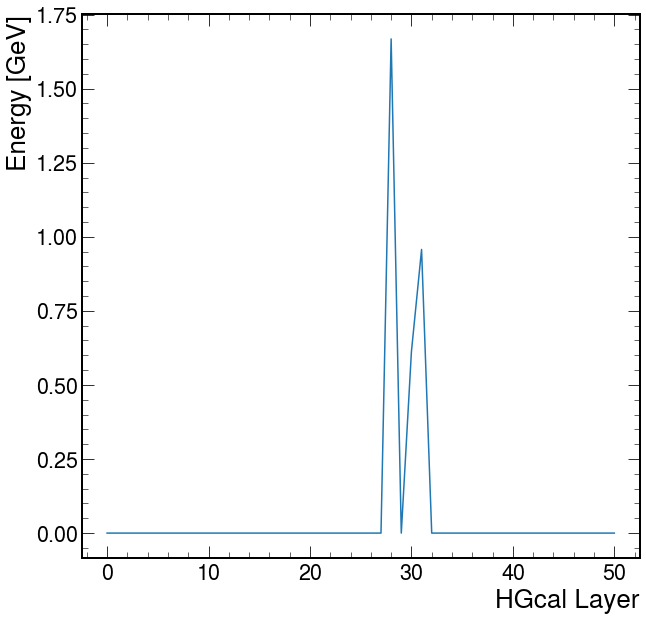

In [38]:
lc0.vertices_indexes

[11, 13, 14, 18, 23, 24, 32, 38, 46, ... 108, 111, 124, 138, 139, 142, 158, 170, 173]
[100, 113, 128, 143, 147]
[33, 39, 41, 49, 58, 60, 72, 73, 85, ... 141, 145, 149, 159, 175, 176, 189, 200, 205]
[190, 206, 221, 247, 288, 301]
[172, 196]
[178, 192, 201, 235, 238, 249, 276, 278]
[144, 186, 188, 209, 217, 219, 233, 244, 246, 272]
[229, 248, 262, 289, 290]
[204, 218, 228, 231, 245, 261, 271, 274, 286, 287, 309]


In [4]:
# f = uproot.open("/eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/close_by_double_pion/production/new_new_ntuples/ntuples_3933206_0.root")
# t = f["ntuplizer/tracksters"]
# t.keys()

# #print(t.arrays(["vertices_indexes"])[0])
# for i in t.arrays(["raw_energy"])[0].raw_energy:
#     print(i)
# for i in t.arrays(["vertices_indexes"])[0].vertices_indexes:
#     print(i)
# print(ak.size(t.arrays(["vertices_indexes"])[0].vertices_indexes))


Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_1015.root ....................................................................................................
Processing file /eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/wredjeb/close_by_two_pions/ntuples_10_600/new_ntuples_14396686_1016.root ......

ValueError: in ListOffsetArray64 attempting to get 544, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.0.2/src/cpu-kernels/awkward_ListArray_getitem_next_array.cpp#L32)